# Bootstrapping to estimate parameter ranges of nonlinear models

When we first introduced ourselves to regression, we focused the regression algorithm’s ability to find the “truth”, i.e. how close to the true parameter values does the algorithm get.

In statistics and boostrapping, the truth is (typically) unknown and there is noise associated with any given measurement. So our question becomes “how confident am I that the parameters of my model are not zero?” And as discussed in class, all kinds of challenges arise when using bootstrapping. Here, we'll try a simple example.

Let's consider one of our equations for bacterial growth:
\begin{align}
\dot{y} = \frac{y^3}{a+y^3}-by
\end{align}

where y is the concentration of bacterium and a and b are parameters that help define the rate of bacterial growth and loss, respectively. 

You have been provided with data, called "Homework11 Data.csv". Use this data for the following excercises. In this file, you'll find the time points sampled and the concentration of bacterium (y) for 5 independent experiments. We will consider data to be independent across time and experiments.

## Part 1: Plot data and perform initial fitting

In the space below, load the data and write the code to fit the parameters of our model to the data using minimize or fsolve. You may want to revisit your previous homeworks. To make things a little easier, I'll give you the first guess for your parameter. Go with (a,b) = (0.3,0.8). After fitting:
   - clearly indicate what were the parameter values and the value of the cost function you implemented.
   - Plot on one plot the data and the fitted model's response

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciopt
import pandas as pd
from scipy import stats
import scipy.integrate as scint
import statsmodels.api as sm
import seaborn as sns

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
dat = pd.read_csv("Homework 6 data.csv")
dat

,Time,Exp1,Exp2,Exp3,Exp4,Exp5
0,10,6.20,4.07,8.13,7.97,7.07
1,20,8.84,5.63,10.90,10.90,9.80
2,30,9.99,9.16,11.00,8.80,10.30
3,50,10.80,11.70,10.40,10.60,8.65


<IPython.core.display.Javascript object>

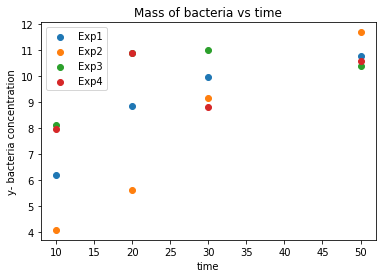

<IPython.core.display.Javascript object>

In [3]:
for i in np.arange(1, dat.columns.size - 1):
    plt.scatter(dat["Time"], dat[f"Exp{i}"], label=f"Exp{i}")

plt.xlabel("time")
plt.ylabel("y- bacteria concentration")
plt.title("Mass of bacteria vs time")
plt.legend()
# plt.scatter(dat['time'],dat['c'])

In [4]:
y = np.array([])
t = np.array([])

for i in dat["Time"]:
    [a] = np.array(dat[dat["Time"] == i])
    a = a[1:]
    t = np.append(t, np.ones_like(a) * i)
    y = np.append(y, a)

<IPython.core.display.Javascript object>

In [5]:
def func(y, t, a, b):
    return y**3 / (a + y**3) - b * y


[y0] = np.array(dat[dat["Time"] == 10])

y0 = y0[1:]
y0 = np.mean(y0)


sol = scint.odeint(func, y0, t, args=(0.3, 0.8))

<IPython.core.display.Javascript object>

In [6]:
def RMSE(par,y,t,guess):
    a, b = par
    # t = np.linspace(10, 50, 100)
    soln = scint.odeint(func, guess, t, args=(a, b))
    error = y - soln.T[0]
    # print(np.shape(y) == np.shape(soln.T[0]))
    #     error = error / 10
    return np.sqrt(np.sum(error**2))


<IPython.core.display.Javascript object>

In [7]:
attempt1 = sciopt.minimize(
    RMSE,
    args=(y, t, y0),
    x0=([0.3, 0.095]),
    bounds=((0, 200), (0, 200)),
    method="SLSQP",
)
a1, b1 = attempt1.x
print(attempt1)

# Gave arbitrary bounds to avoid negative values

     fun: 6.184571597856989
     jac: array([0.00066495, 0.00036359])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.29999986, 0.09498143])


<IPython.core.display.Javascript object>

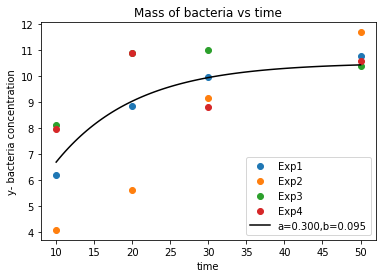

<IPython.core.display.Javascript object>

In [22]:
for i in np.arange(1, dat.columns.size - 1):
    plt.scatter(dat["Time"], dat[f"Exp{i}"], label=f"Exp{i}")

tt = np.linspace(min(t), max(t), 100)
sol3 = scint.odeint(func, y0, tt, args=(a1, b1))
plt.plot(tt, sol3.T[0], "k", label=f"a={a1:.3f},b={b1:.3f}")
plt.xlabel("time")
plt.ylabel("y- bacteria concentration")
plt.title("Mass of bacteria vs time")
plt.legend()

## values of fit parameters are- are -> a = 0.325 and b = 0.095

## Part 2: Use sampling with replacement to create distributions of parameters that fit the data

Our hypothesis is that both a and b are greater than 0. Use the bootstrap method to create distributions of estimates of our parameter values. We can do this by, **for each iteration:**
   - Resample the data at each time point using sample with replacement (search online how to do).
   - Use minimize to refit the model to the resampled data
   - Save the fitted parameter estimates and the value of the cost function.
   
Do this for at least 200 iterations. HINT: this code may take a long time to run. It would be best to get the code working with only a few iterations. And once happy, then try 200. After completing, plot histograms of the fitted parameter values and cost function values. Figures must be clearly labeled and obvious to read. 

Based on these data, what is the p value for the null hypothesis that a and b are equal to zero? Calculate the one sided p value, based on the idea that we expect them to be greater than zero.
   

In [26]:
iterations = 200


values_a = np.array([])
values_b = np.array([])
costf = np.array([])
for j in np.arange(iterations):
    sample = np.array([])
    for i in dat["Time"]:
        [k] = np.array(dat[dat["Time"] == i])
        k = k[1:]
        sample = np.concatenate([sample, np.random.choice(k, 5, replace=True)])
#         print(sample)
        guess = sample[0:5].mean()
    attempt = sciopt.minimize(
        RMSE,
        args=(sample, t,guess),
        x0=([0.3, 0.8]))

    values_a = np.concatenate([values_a, attempt.x[0]],axis=None)
    values_b = np.concatenate([values_b, attempt.x[1]],axis=None)
    costf = np.concatenate([costf, attempt.fun],axis=None)


<IPython.core.display.Javascript object>

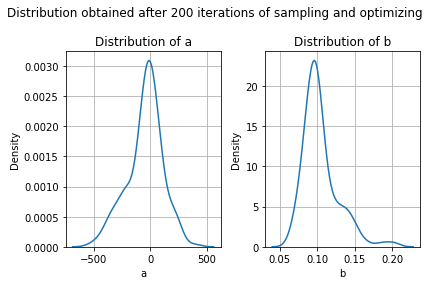

<IPython.core.display.Javascript object>

In [27]:
fig, axs = plt.subplots(1, 2)
axs[0] = sns.kdeplot(values_a, ax=axs[0])
axs[1] = sns.kdeplot(values_b, ax=axs[1])
# axs[2] = sns.kdeplot(costf, ax=axs[2])

axs[0].set_xlabel("a")
axs[1].set_xlabel("b")
# axs[2].set_xlabel("Costfunction")

axs[0].set_title("Distribution of a")
axs[1].set_title("Distribution of b")
# axs[2].set_title("Distribution of costfunction")

fig.suptitle(
    rf"Distribution obtained after {iterations} iterations of sampling and optimizing"
)

plt.tight_layout()

for i in axs:
    i.grid()

plt.show()

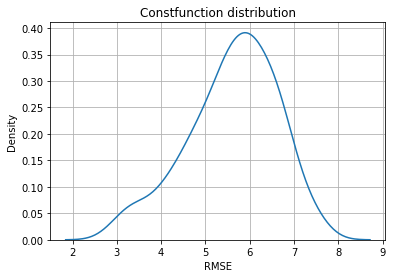

<IPython.core.display.Javascript object>

In [28]:
sns.kdeplot(costf)
plt.title("Constfunction distribution")
plt.xlabel("RMSE")
plt.grid()

In [56]:
pa = stats.ttest_1samp(values_a, 0, alternative="greater")
pb = stats.ttest_1samp(values_b, 0, alternative="greater")
print(f"p-value for a=0 is {pa[1]:.5f} and for b=0 is {pb[1]:.5f}")

p-value for a=0 is 0.99998 and for b=0 is 0.00000


<IPython.core.display.Javascript object>

### From the pvalues, we can see that b is >0 while we can't say that a is >=0

## Part 3 Analyze fit results

One a single figure, plot the model's response vs time for all 200 estimates of the parameter values. Are the fits reasonable? Should any of the fits be discounted? Why so? Does this change how you define your p values above? **Defend your answer here and include any plots as necessary:**



Text(0.5, 1.0, 'Mass of bacteria vs time')

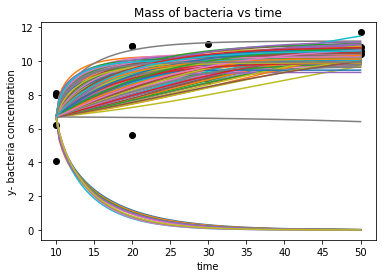

<IPython.core.display.Javascript object>

In [30]:
for i in np.arange(iterations):
    sol = scint.odeint(func, y0, tt, args=(values_a[i], values_b[i]))
    plt.plot(tt, sol)

for i in np.arange(1, dat.columns.size - 1):
    plt.scatter(dat["Time"], dat[f"Exp{i}"], color="k")

plt.xlabel("time")
plt.ylabel("y- bacteria concentration")
plt.title("Mass of bacteria vs time")
# plt.legend()

### Yes, there are parameters/fits which can be discounted.

- The fits which show decreasing y wrt time can be discounted. // These are the fits which have a<0

- The fits which have an increasing $\frac{dy}{dt}$ wrt time can be discounted.

- All the fits above the arbitrary separation line on the graph below can be considered good fits, after satisfying the two steps above



### I am not sure how our way of calculating p-values will change. This is because the fits which were discounted had values of 'a'<0. If we discount those fits, then p('a'>0) will be 1. This would mean that we are manually constraining 'a' and not statistically concluding that 'a' will be >= 0.



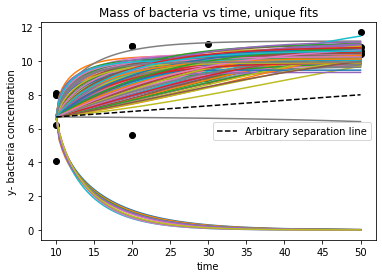

<IPython.core.display.Javascript object>

In [52]:
dat2 = pd.DataFrame()
dat2["a"] = values_a
dat2["b"] = values_b
# dat2["costf"] = costf
dat2 = dat2.drop_duplicates()
# dat2 = dat2[dat2["a"] > 0]
# dat2 = dat2[dat2["b"] < 0.17]

for i in np.arange(1, dat.columns.size - 1):
    plt.scatter(dat["Time"], dat[f"Exp{i}"], color="k")
for i in dat2.iterrows():
    # print(i[1][0])
    sol = scint.odeint(func, y0, tt, args=(i[1][0], i[1][1]))
    plt.plot(tt, sol)
plt.plot([10, 50], [y0, 8], "k--", label="Arbitrary separation line")
plt.xlabel("time")
plt.ylabel("y- bacteria concentration")
plt.title("Mass of bacteria vs time, unique fits")
plt.legend()

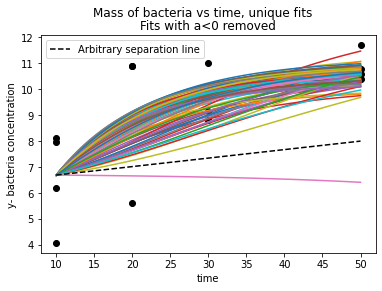

<IPython.core.display.Javascript object>

In [53]:
dat2 = dat2[dat2["a"] > 0]
for i in np.arange(1, dat.columns.size - 1):
    plt.scatter(dat["Time"], dat[f"Exp{i}"], color="k")
for i in dat2.iterrows():
    # print(i[1][0])
    sol = scint.odeint(func, y0, tt, args=(i[1][0], i[1][1]))
    plt.plot(tt, sol)
plt.plot([10, 50], [y0, 8], "k--", label="Arbitrary separation line")
plt.xlabel("time")
plt.ylabel("y- bacteria concentration")
plt.suptitle("Mass of bacteria vs time, unique fits")
plt.title("Fits with a<0 removed")
plt.legend()

# Project topic-

### The relation between covid infection rates and the political orientation of the population and their level of education.

$y$ = infection rates

$x_1$ = political orientation

$x_2$ = level of education

- potentially useful variable to add more context: The field of the people's education,i.e., a degree in arts vs a degree in chem e